# Hyper-Parameter Optimization for the Classification of astronomical sources using multi-wavelength photometric data and machine learning

Hyper-Parameter Optmization: <br>
Mogammad Yaaseen Jones <br>
email: yaasjones@gmail.com <br>
github: https://github.com/yaaseenjones/ <br>
<br>
Classification Code adopted from: <br>
Chaka Mofokeng <br>
email: mofokeng.chk@gmail.com <br>
github: https://github.com/Mofokeng-C/

This is a tutorial that uses two machine learning algorithms: random forest and k-nearest neighbor classifiers. It uses corrected photometric magnitudes from SDSS together with corresponding WISE magnitudes, which are used to disentangle three different classes (stars, galaxies and quasars).

This tutorial was developed using some of the code from sci-kit learn tutorials ([http://scikit-learn.org/stable/tutorial/index.html](http://url))

In [1]:
# Loading necessary modules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
import timeit

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

#%matplotlib inline

In [2]:
def Preprocessing(filename, task='C', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    
    INPUTS
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    RETURNS
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    
    
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N]


    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
   
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # conditions on magnitude values
    cond_u = indices[np.logical_and(u>13.0,u<22.0)]
    cond_g = indices[np.logical_and(g>14.0,g<22.2)]
    cond_r = indices[np.logical_and(r>14.0,r<22.2)]
    cond_i = indices[np.logical_and(i>14.0,i<21.3)]
    cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
    # index of where all conditions are true
    cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
    cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
    cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
    cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
    # get values that satisfy the conditions
    class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
    class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
    redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
    #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 

    x = np.array([x[i] for i in cond_u_g_r_i_z])
    y = pd.factorize(class_0)[0]

    #splitting data into 80% and 20% train and test datasets, respectively
    x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y,cond_u_g_r_i_z, test_size=0.20) 

    return x_train, x_test, y_train, y_test, i_train, i_test

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')


In [4]:
def knn_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the kNN classifyer
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)  
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    #y_predict.append(y_ks)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for knn: {} seconds'.format(elapsed))
    print('Accuracy for kNN is: {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))
    
    return y_ks, proba

In [5]:
def rf_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the RF classifier
    parameters:
    
    INPUTS
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    RETURNS
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels
    importance - ranking of the important features of the dataset
    acu - accuracy'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)
    importance = ks.feature_importances_ 
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for rf: {} seconds'.format(elapsed))
    print('Accuracy for rf {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))
    
    return y_ks, proba, importance

In [6]:
def roc_curve(y_t, proba, name=''):
    '''This function returns the roc curve plot 
    paramters:
    
    INPUT
    y_t - test dataset labels
    proba - proabaility of the predicted label by the classifier
    name - name of the classifyer
    
    RETURNS
    - plot of the roc curve of the data'''
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(proba[0])):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test, proba[:,i], pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    #Plot the roc_curve
    pl.figure(figsize=(11,11))
    
    pl.title(name)
    pl.xlabel('false positive rate')
    pl.ylabel('true positive rate')
    
    pl.plot(fpr[0],tpr[0], label='ROC curve for GALAXIES (area = %0.2f)' %roc_auc[0])
    pl.plot(fpr[1],tpr[1], label='ROC curve for STARS (area = %0.2f)' %roc_auc[1])
    pl.plot(fpr[2],tpr[2], label='ROC curve for QSOs (area = %0.2f)' %roc_auc[2])
    pl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    pl.grid(True)
    pl.legend(loc=4)
    

In [7]:
def feature_importance(cl,importance,x_tr, x_t, y_tr, y_t,thresh=0.15):
    '''This function Create a selector object that will use 
    the random forest classifier to identify 
    features that have an importance of more than the given
    threshold.
   
    INPUTS
    cl - the algorithm to perform classification
    importance - ranking of the important features of the dataset
    thresh - feature importance threshold, default thresh=0.15
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    RETURNS
    plot of feature importance.
    '''
    
    sfm = SelectFromModel(cl, threshold=thresh)
    
    # Train the selector
    sfm.fit(x_tr, y_tr)

    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    x_important_train = sfm.transform(x_tr)
    x_important_test = sfm.transform(x_t)

    # Create a new random forest classifier for the most important features
    rs_important = RandomForestClassifier(30)

    # Train the new classifier on the new dataset containing the most important features
    rs_important.fit(x_important_train, y_tr)
    y_rs_important = rs_important.predict(x_important_test)
    proba_ = rs_important.predict_proba(x_important_test)
    acu_important=acc(y_t, y_rs_important)
    
    print ('\n\nAccuracy for RF (feature selection): ' + repr(acu_important))# printing out your results
    print (metrics.classification_report(y_t, y_rs_important,target_names=['SFGs', 'STARS', 'QSOs'], digits=4))



    std = np.std([cl.feature_importances_ for tree in cl.estimators_],axis=0)
    
    t_label = ['r','u-g' , 'g-r', 'r-i', 'i-z', 'z-w1', 'w1-w2']
    labels = []
    
    indices = np.argsort(importance)[::-1]
    for f in range(len(t_label)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
        labels.append(t_label[indices[f]])
    
    # Plot the feature importances of the forest
    
    #i = np.arange(x.shape[1])
    #labels = t_label[indices[i]]
    
    pl.figure(figsize=(11,11))
    pl.title("Feature importances")
    pl.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    pl.xticks(range(len(labels)),labels, rotation = 45 )
    pl.xlim([-1, len(labels)])
    #pl.savefig('rf_feature_importance.png')

### Load data from the catalogue

In [8]:
#Loading data from the catalogue
#in this case the file is in the same directory as the jupyter notebook
#file = osp.join("../Hons/","sdss_all_small_dr16_allwise_red.fits.gz") #to specify your own "path/to/file" 
                                                               #change the first parameter (".")
file = osp.join("sdss_all_small_dr16_allwise_red.fits.gz")
fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f4f0b327350>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f4f0b2ca310>]>

In [9]:
N_all = len(data) # all rows from the catalogue (= 3840668)

### Visualizing features of the data 

In [10]:
#Change the value of n to select only a subset of the data

#N = 5000#len(data)
N=1000
data = data[:N]

ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['w1mpro']
w2 = data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T

In [11]:
data['specclass']

chararray(['STAR', 'STAR', 'GALAXY', 'STAR', 'GALAXY', 'STAR', 'GALAXY',
           'GALAXY', 'QSO', 'STAR', 'STAR', 'STAR', 'GALAXY', 'GALAXY',
           'STAR', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY',
           'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO',
           'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
           'GALAXY', 'GALAXY', 'GALAXY', 'STAR', 'GALAXY', 'STAR', 'STAR',
           'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
           'GALAXY', 'STAR', 'GALAXY', 'GALAXY', 'STAR', 'STAR', 'GALAXY',
           'STAR', 'STAR', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY',
           'GALAXY', 'STAR', 'STAR', 'STAR', 'GALAXY', 'STAR', 'STAR',
           'GALAXY', 'STAR', 'GALAXY', 'STAR', 'GALAXY', 'GALAXY',
           'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'QSO',
           'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY',
           'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAX

In [12]:
data['specsubclass']

chararray(['M2', 'F9', '', 'K3', 'STARFORMING', 'F5', 'STARFORMING', '',
           'BROADLINE', 'K7', 'F3/F5V (30743)', 'M5', '', '', 'M0',
           'BROADLINE', 'STARFORMING', '', '', '', '', '', '', '', '', '',
           'BROADLINE', '', '', '', '', 'STARFORMING', '', '', '', '',
           'M3', '', 'M3', 'K1', 'BROADLINE', '', 'STARBURST', '', '', '',
           '', 'M0', 'STARFORMING', '', 'M2', 'M3', '', 'M3', 'K7',
           'STARFORMING', 'STARFORMING', '', '', '', 'STARBURST', 'M0',
           'M1', 'M4', '', 'F5', 'M2', 'STARBURST', 'K7', '',
           'A1III (225180)', '', 'STARFORMING', 'STARFORMING', '', '', '',
           'BROADLINE', 'AGN', 'BROADLINE', '', '', 'STARFORMING', '', '',
           '', '', '', '', '', '', 'STARBURST', '', 'STARFORMING', '',
           'STARFORMING', 'BROADLINE', 'STARFORMING', 'K3', '', '', 'K5',
           'STARFORMING', '', '', 'STARFORMING', '', '', 'STARFORMING',
           '', '', '', '', '', '', '', 'STARFORMING', '', '', '',
   

In [13]:
specclass = [str(s) for s in data['specclass']]

In [14]:
cl = pd.DataFrame(specclass,columns=["specclass"])
x_data = df = pd.DataFrame(x, columns=["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"])

In [15]:
df = pd.concat([x_data,cl], axis=1, sort=False)

In [16]:
df

,r,u - g,g - r,r - i,i - z,z - w1,w1 - w2,specclass
0,18.344410,2.806168,1.377230,0.999796,0.525867,2.147747,0.105000,STAR
1,14.922372,1.611107,0.527822,0.166768,0.076180,1.340424,-0.081000,STAR
2,18.105097,1.625917,1.502785,0.573378,0.362349,2.527370,0.244000,GALAXY
3,17.040960,1.845491,0.684391,0.238184,0.111483,1.526294,-0.061000,STAR
4,17.098881,0.775818,0.324558,0.171919,0.166197,1.742765,0.056999,GALAXY
...,...,...,...,...,...,...,...,...
995,16.904079,2.076456,1.044004,0.270443,0.343554,2.340083,0.182000,GALAXY
996,17.642422,1.518974,0.760418,0.375420,0.289270,2.365731,0.176001,GALAXY
997,18.943567,3.339430,1.726215,0.614639,0.422123,3.137805,-0.009000,GALAXY
998,20.451405,0.560860,2.000134,1.007309,0.476524,3.915571,0.068000,GALAXY


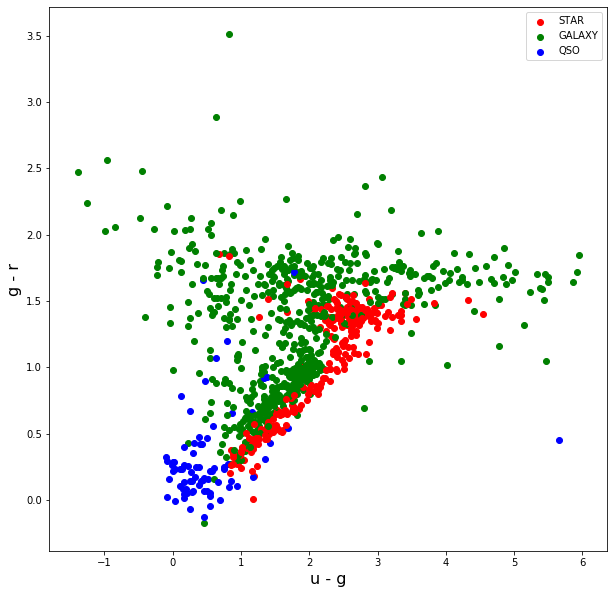

In [17]:
# create a figure and axis
fig, ax = pl.subplots(figsize=(10,10))
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# defining specific colours for each class
colors = {'STAR':'r', 'GALAXY':'g', 'QSO':'b'}

# plot each data point
#naxis = len(x.shape[1])
for i in range(len(x[:,0])):
    ax.scatter(x[:,ilabels[0]][i], x[:,ilabels[1]][i],label=data['specclass'][i],color=colors[data['specclass'][i]])
# set a title and labels
#ax.set_title('Iris Dataset')
ax.set_xlabel(labels[ilabels[0]])
ax.set_ylabel(labels[ilabels[1]])
handles, labels = pl.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys())

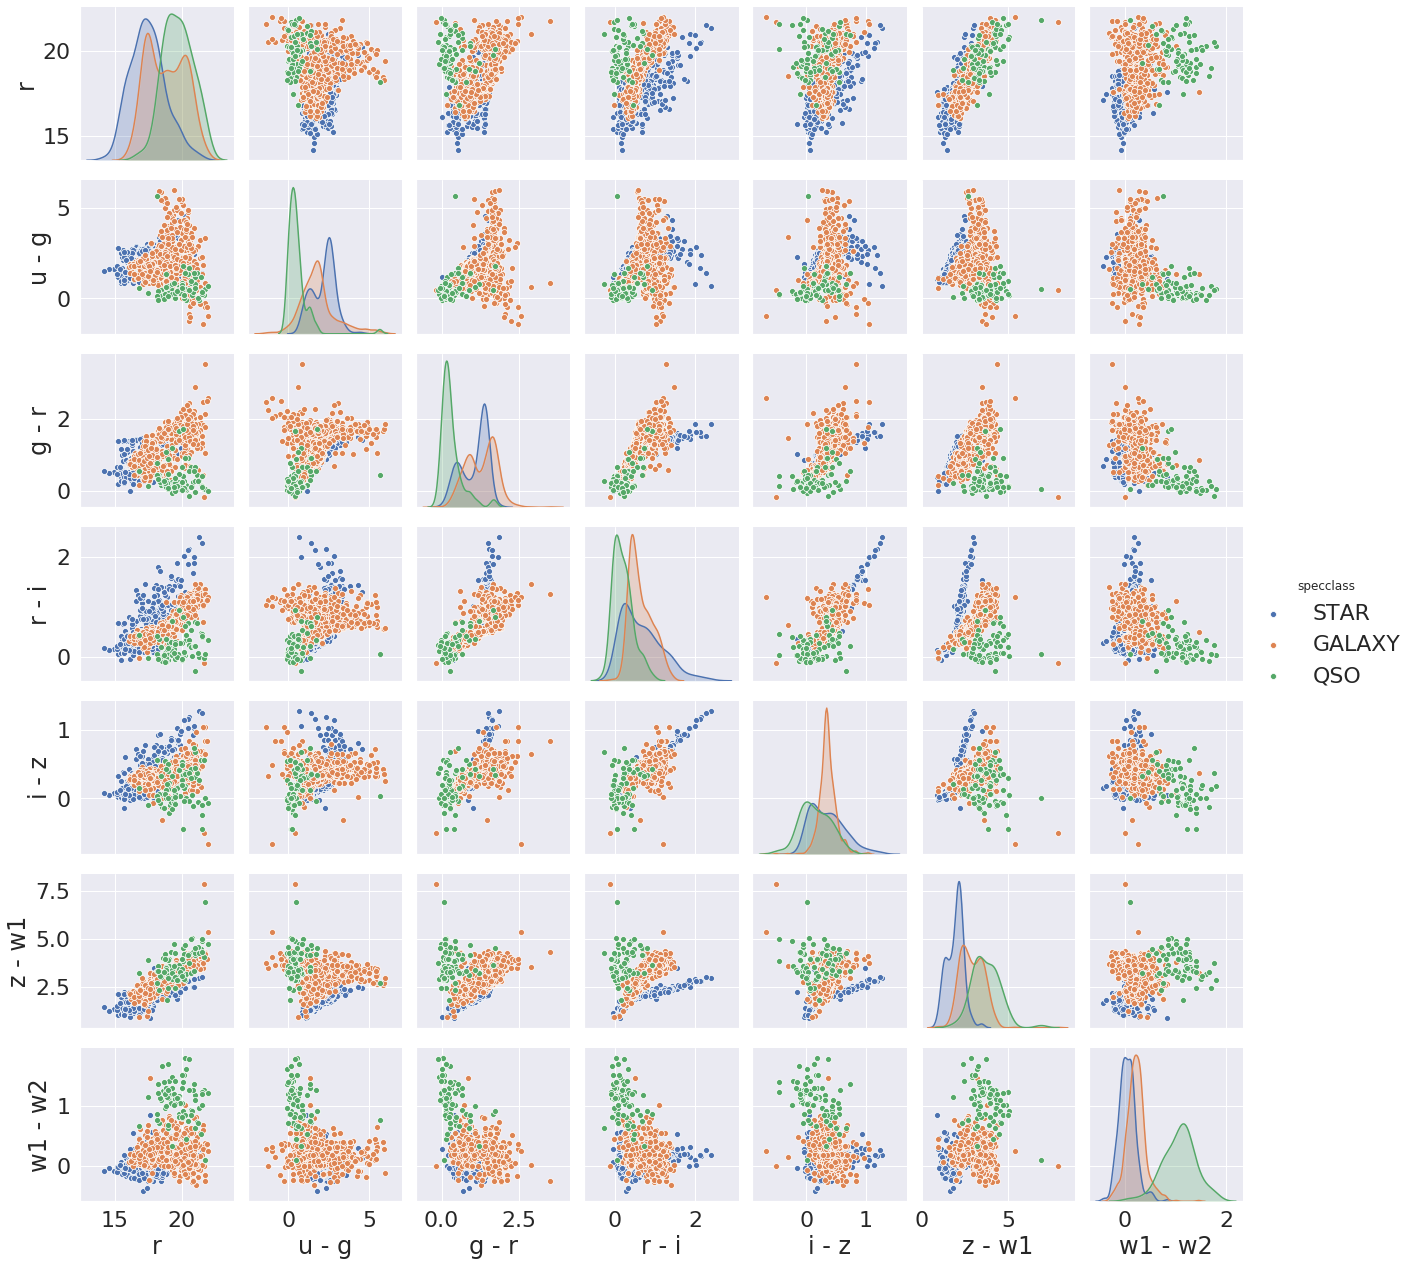

In [18]:
import seaborn as sns
sns.set(font_scale=2)
sns.pairplot(df, hue="specclass",)

## Classification

Classification is a process of grouping objects according to
shared properties and is applied to help understand the origin and evolution of the
objects under consideration. It can be performed using different observed properties of objects, properties like colour, morphology or size. For instance, in the tutorrial to follow, classification is performed differentiate between three classes of [astronomical sources](https://en.wikipedia.org/wiki/Astronomical_object) (stars, galaxies, quasars) using colour properties derived from photometric magnitudes. </br>

### Preprocessing the data for classification

In [19]:
# preprocess the data
x_train, x_test, y_train, y_test, i_train, i_test = Preprocessing(file,'C',N=N_all)

### Performing classification

#### Using the K-Nearest Neighbour Classification

In [20]:
#kNearestNeighbor
# using 10 nearest neighbors
ks = KNeighborsClassifier(n_neighbors=10)

y_knn, proba_knn = knn_classifier(ks, x_train, x_test, y_train, y_test)

Elapsed time for knn: 46.161554531005095 seconds
Accuracy for kNN is: 0.980282862610815
              precision    recall  f1-score   support

        SFGs     0.9721    0.9779    0.9750     50838
       STARS     0.9818    0.9822    0.9820    119907
        QSOs     0.9841    0.9786    0.9813     62301

    accuracy                         0.9803    233046
   macro avg     0.9793    0.9795    0.9794    233046
weighted avg     0.9803    0.9803    0.9803    233046



#### Using the Random Forest Classification

In [21]:
# RandomForest
# using 30 number of decision trees
rf1 = RandomForestClassifier(30)

y_rf1, proba_rf, importance1 =rf_classifier(rf1, x_train, x_test, y_train, y_test)

Elapsed time for rf: 186.93970893300138 seconds
Accuracy for rf 0.9845652789578023
              precision    recall  f1-score   support

        SFGs     0.9855    0.9834    0.9845     50838
       STARS     0.9846    0.9876    0.9861    119907
        QSOs     0.9837    0.9796    0.9817     62301

    accuracy                         0.9846    233046
   macro avg     0.9846    0.9836    0.9841    233046
weighted avg     0.9846    0.9846    0.9846    233046



### Evaluating the performance of the classifiers

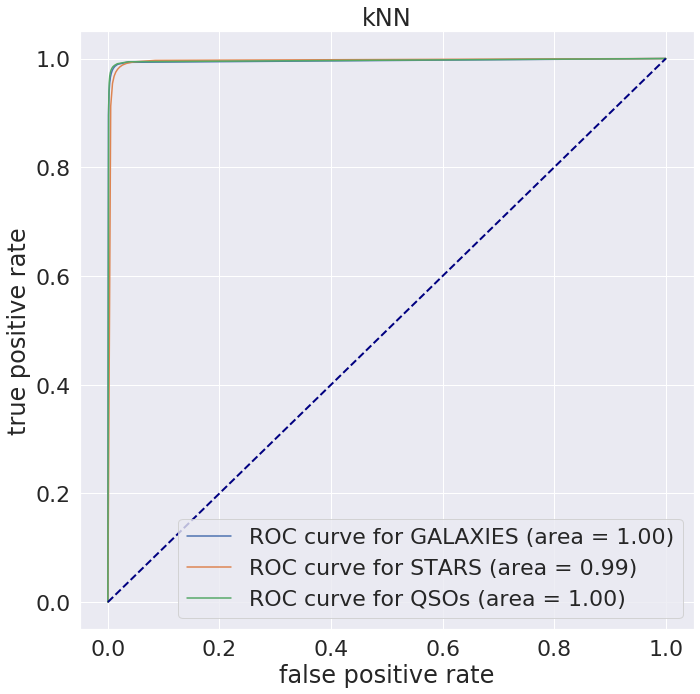

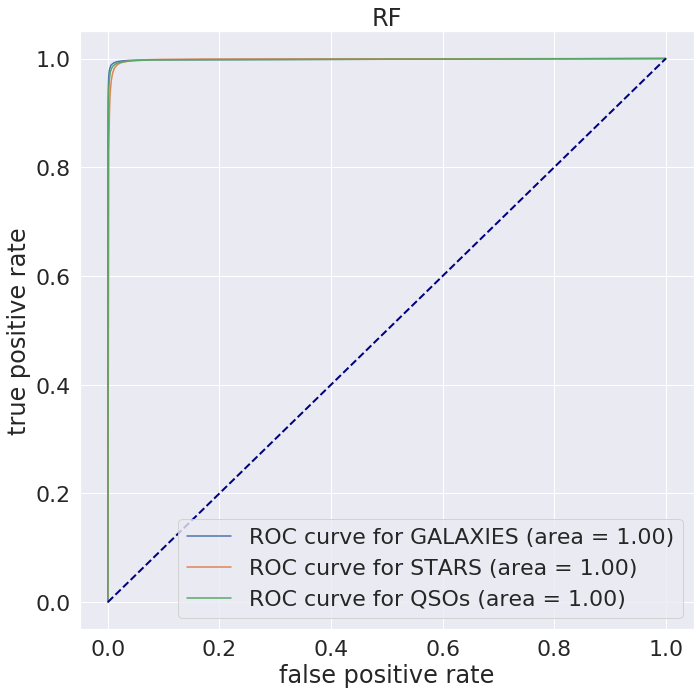

In [22]:
# ROC curve
roc_curve(y_test, proba_knn, 'kNN') #kNN roc_curve
roc_curve(y_test, proba_rf, 'RF') #RF roc_curve

#### Confusion matrix for K-Nearest Neighbour Method

Confusion matrix, without normalization
[[ 49712    952    174]
 [  1325 117773    809]
 [   103   1232  60966]]
Normalized confusion matrix
[[0.98 0.02 0.  ]
 [0.01 0.98 0.01]
 [0.   0.02 0.98]]


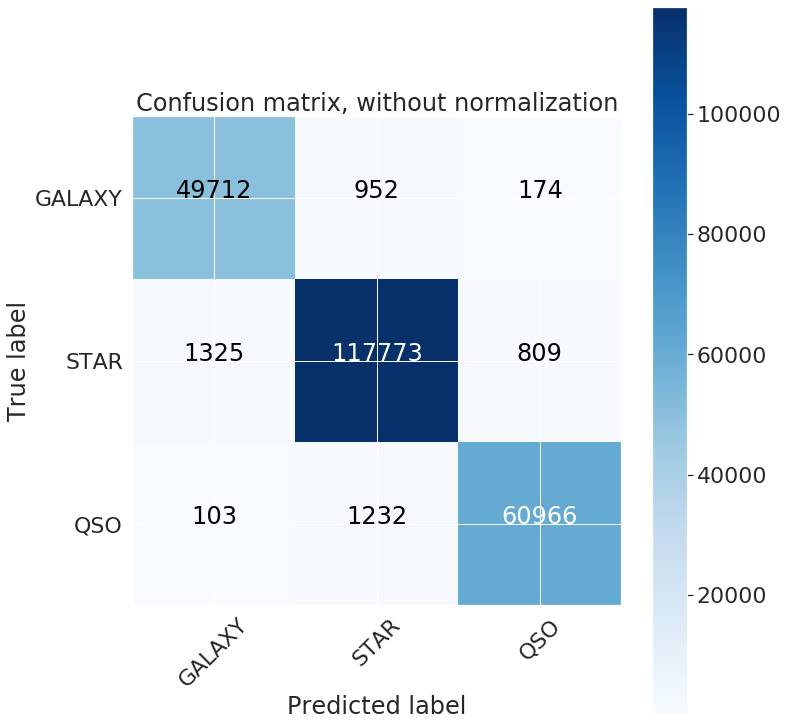

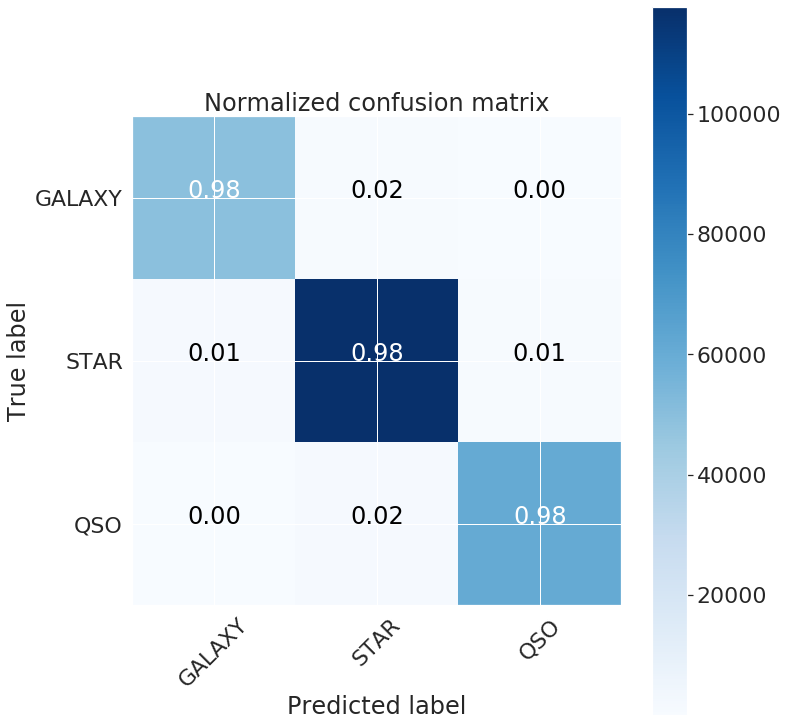

In [23]:
# Compute confusion matrix for kNN classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

#### Confusion matrix for Random Forest Method

Confusion matrix, without normalization
[[ 49996    670    172]
 [   646 118421    840]
 [    88   1181  61032]]
Normalized confusion matrix
[[0.98 0.01 0.  ]
 [0.01 0.99 0.01]
 [0.   0.02 0.98]]


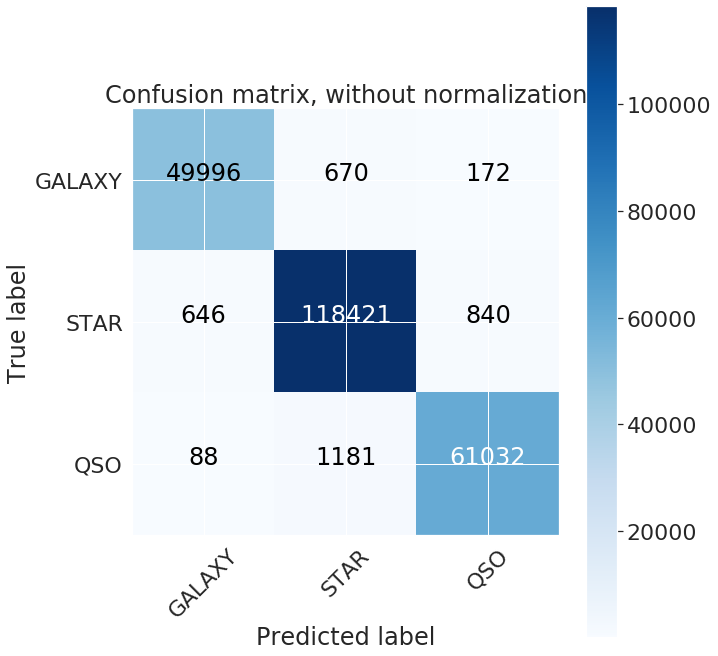

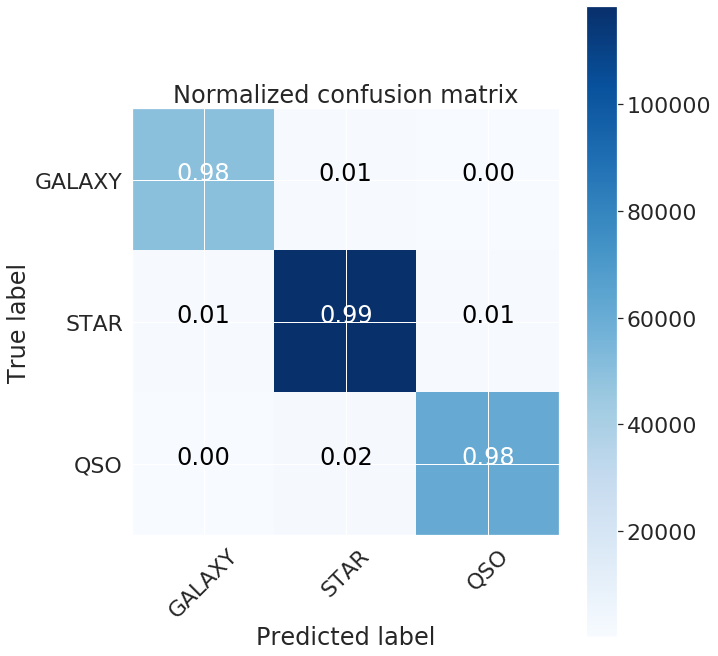

In [24]:
# Compute confusion matrix for Rf classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_rf1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

### Feature importance



Accuracy for RF (feature selection): 0.9538889317988724
              precision    recall  f1-score   support

        SFGs     0.9262    0.9253    0.9257     50838
       STARS     0.9570    0.9572    0.9571    119907
        QSOs     0.9706    0.9708    0.9707     62301

    accuracy                         0.9539    233046
   macro avg     0.9512    0.9511    0.9512    233046
weighted avg     0.9539    0.9539    0.9539    233046

1. feature 6 (0.262622)
2. feature 1 (0.171077)
3. feature 5 (0.154145)
4. feature 3 (0.146324)
5. feature 2 (0.100223)
6. feature 4 (0.085629)
7. feature 0 (0.079979)


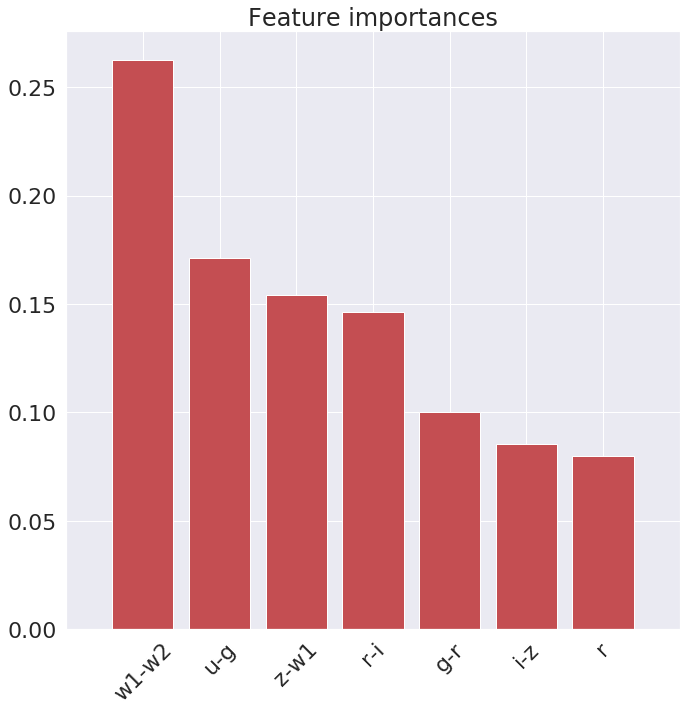

In [25]:
feature_importance(rf1, importance1, x_train, x_test, y_train, y_test)

# Hyperparameter Optimization

Since it was clear that the Random Forest Classification Method was most accurate, it will have it's parameters optimised to further improve accuracy

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### Default Parameters:
- n_estimators: deafult(100)
- max_depth: default(none)
- min_samples_split: default(2)
- min_samples_leaf: default(1)

##### Used Parameters:
- n_estimators: 30
- max_depth: default(none)
- min_samples_split: default(2)
- min__samples_leaf: default(1)

So, using help from https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6 I attempt to find the best hyperparamters

#### Validation Curve

In [26]:
from sklearn.model_selection import validation_curve

##### Plotting Validation Curve Function

Using the code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py to plot the validation code

In [27]:
def Validation_Plot(train_scoreNum, test_scoreNum, parameter, num_est):
    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    test_scores_mean = np.mean(test_scoreNum, axis=1)
    test_scores_std = np.std(test_scoreNum, axis=1)

    pl.title("Validation Curve with Random Forest")
    pl.xlabel("Parameter: {}".format(parameter))
    pl.ylabel("Accuracy")
    lw = 2
    print(100*np.amax(test_scoreNum))
    pl.plot(num_est, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    pl.fill_between(num_est, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    pl.plot(num_est, test_scores_mean, label="Test score",
                 color="navy", lw=lw)
    pl.fill_between(num_est, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    pl.legend(loc="best")
    pl.show()

#### Testing Validation Curve on Hyper-Parameters

In [28]:
# n_estimator parameter
num_est=[10, 30, 50]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est)

98.44826938858702


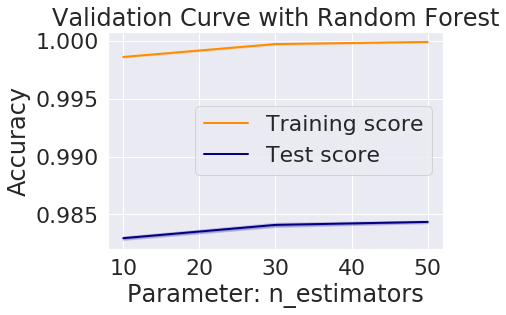

In [29]:
Validation_Plot(train_scoreNum, test_scoreNum, 'n_estimators', num_est)

In [30]:
# max_depth parameter
max_depth_est=[10, 15, 20, 50]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth_est)

98.48367008694626


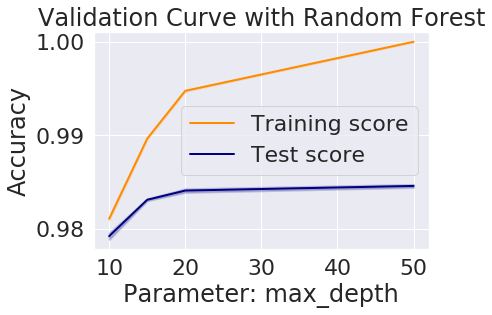

In [31]:
Validation_Plot(train_scoreNum, test_scoreNum, 'max_depth', max_depth_est)

In [32]:
# min_sample_split parameter
min_samples_split_est = [2, 5, 10]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split_est)

98.47829818275441


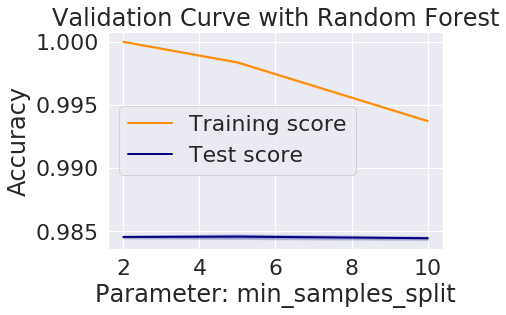

In [33]:
Validation_Plot(train_scoreNum, test_scoreNum, 'min_samples_split', min_samples_split_est)

In [34]:
# min_sample_leaf parameter
min_samples_leaf_est = [1, 2, 3]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train,
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf_est)

98.46917977214702


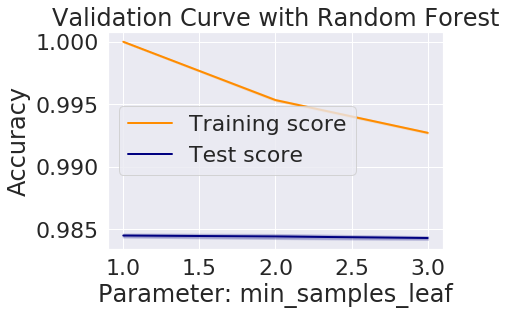

In [35]:
Validation_Plot(train_scoreNum, test_scoreNum, 'min_samples_leaf', min_samples_leaf_est)

#### Compare Optimized Parameters with default Parameters

In [36]:
rf2 = RandomForestClassifier(n_estimators = 50,
                            max_depth = 15,
                            min_samples_split = 2,
                            min_samples_leaf = 1)
                            
y_rf2, proba_rf, importance2 =rf_classifier(rf2, x_train, x_test, y_train, y_test)

Elapsed time for rf: 166.1073645990109 seconds
Accuracy for rf 0.9836298413188812
              precision    recall  f1-score   support

        SFGs     0.9866    0.9783    0.9824     50838
       STARS     0.9825    0.9880    0.9853    119907
        QSOs     0.9835    0.9795    0.9815     62301

    accuracy                         0.9836    233046
   macro avg     0.9842    0.9819    0.9830    233046
weighted avg     0.9836    0.9836    0.9836    233046



Before Optimization


Accuracy for RF (feature selection): 0.9111591702925602
              precision    recall  f1-score   support

        SFGs     0.8470    0.8429    0.8449     50838
       STARS     0.9189    0.9204    0.9196    119907
        QSOs     0.9483    0.9492    0.9487     62301

    accuracy                         0.9112    233046
   macro avg     0.9047    0.9041    0.9044    233046
weighted avg     0.9111    0.9112    0.9111    233046

1. feature 6 (0.262622)
2. feature 1 (0.171077)
3. feature 5 (0.154145)
4. feature 3 (0.146324)
5. feature 2 (0.100223)
6. feature 4 (0.085629)
7. feature 0 (0.079979)
After Optimization


Accuracy for RF (feature selection): 0.9104640285608849
              precision    recall  f1-score   support

        SFGs     0.8446    0.8439    0.8443     50838
       STARS     0.9190    0.9189    0.9189    119907
        QSOs     0.9476    0.9486    0.9481     62301

    accuracy                         0.9105    233046
   macro avg     0.9038 

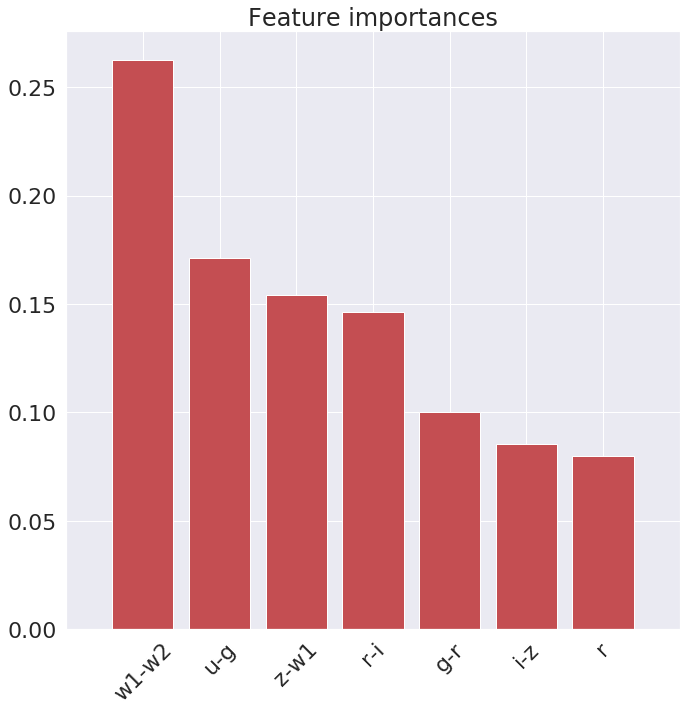

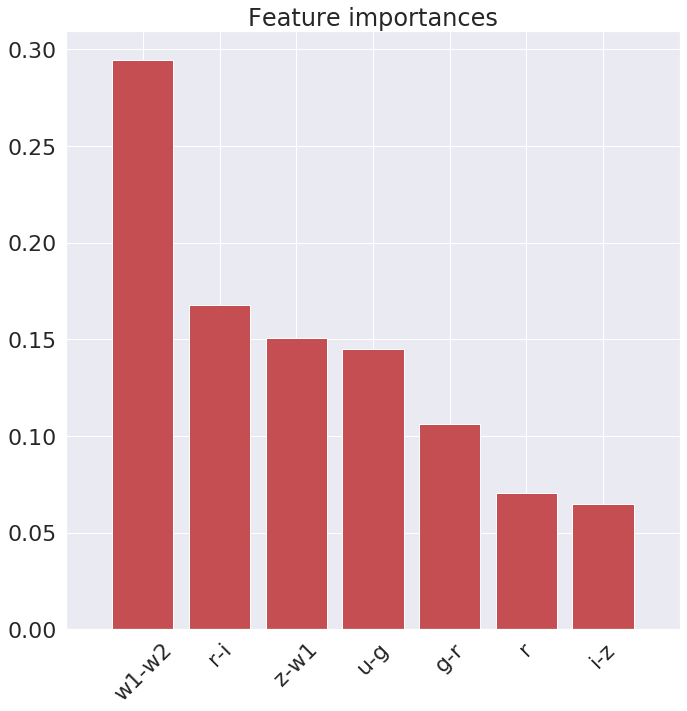

In [37]:
print('Before Optimization')
feature_importance(rf1,importance1,x_train, x_test, y_train, y_test)
print('After Optimization')
feature_importance(rf2,importance2,x_train, x_test, y_train, y_test)

##### Exhaustive Grid Search

Grid Search does an exhaustive check which checks all combinations of the best hyperparameters

In [38]:
from sklearn.model_selection import GridSearchCV

hyperF = dict(n_estimators = num_est, 
              max_depth = max_depth_est, 
              min_samples_split = min_samples_split_est, 
              min_samples_leaf = min_samples_leaf_est)

gridF = GridSearchCV(rf2, hyperF, cv = 3, verbose = 1, 
                      n_jobs = 2)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 19.1min
/home/yaaseen/Applications/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 104.2min
[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed: 219.5min finished


In [39]:
print(bestF)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=50),
             n_jobs=2,
             param_grid={'max_depth': [10, 15, 20, 50],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 50]},
             verbose=1)


Confusion matrix, without normalization
[[ 49996    670    172]
 [   646 118421    840]
 [    88   1181  61032]]
Normalized confusion matrix
[[0.98 0.01 0.  ]
 [0.01 0.99 0.01]
 [0.   0.02 0.98]]
Confusion matrix, without normalization
[[ 49733    916    189]
 [   599 118474    834]
 [    79   1198  61024]]
Normalized confusion matrix
[[0.98 0.01 0.  ]
 [0.01 0.99 0.01]
 [0.   0.02 0.98]]


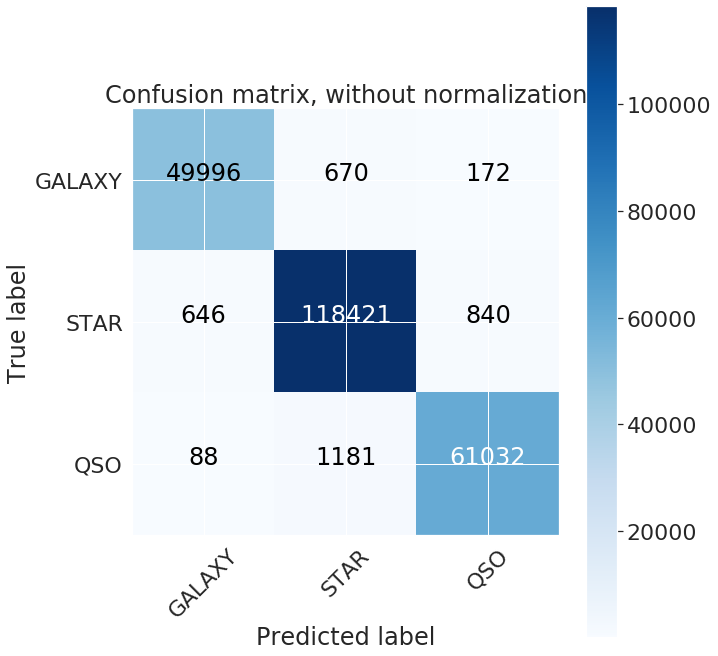

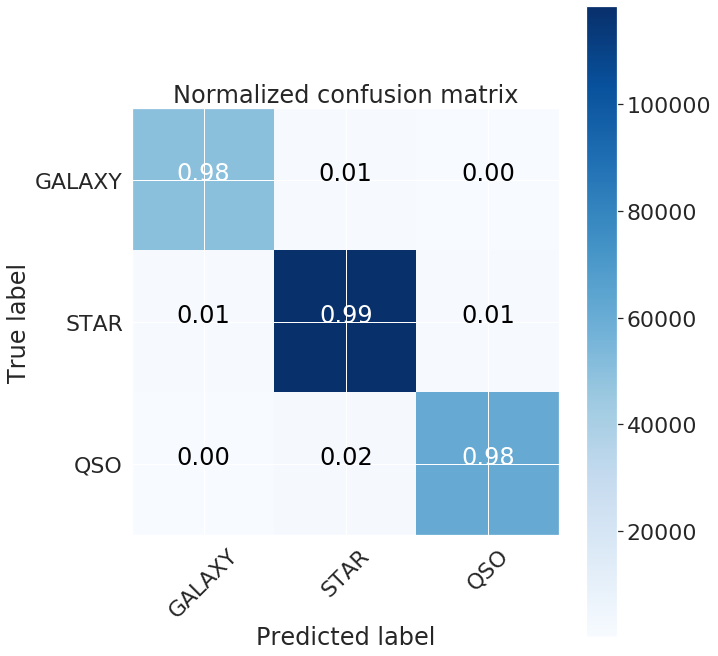

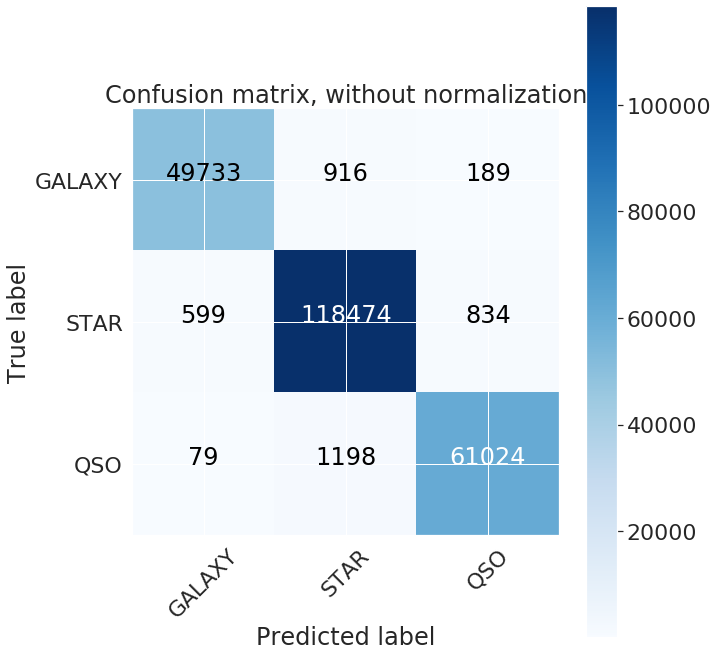

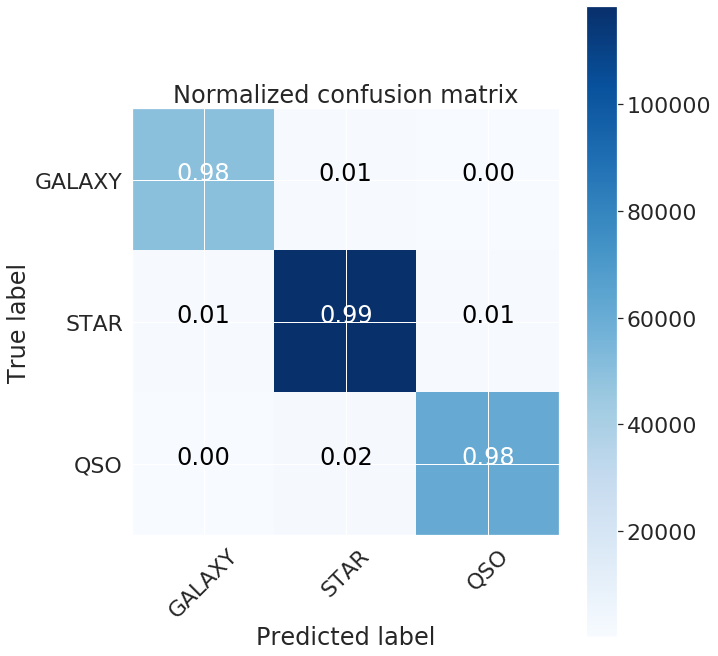

In [40]:
# Compute confusion matrix for Rf classifier BEFORE
cnf_matrix1 = metrics.confusion_matrix(y_test, y_rf1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix1, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')
###################################################################################
# Compute confusion matrix for Rf classifier AFTER
cnf_matrix2 = metrics.confusion_matrix(y_test, y_rf2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix2, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')